# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, Rescaling, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomCrop, RandomTranslation, RandomContrast
from keras.applications import ResNet50, MobileNet, MobileNetV2, VGG16, Xception
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Downloading the dataset

In [79]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

def remove_images():
    print("Removing images...")
    for i in range(1, 4):
        os.remove(PATH_DATASET+"Au/Au ("+str(i)+").jpg")
        os.remove(PATH_DATASET+"Tp/Tp ("+str(i)+").jpg")
    print("Removing complete.")

In [80]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


In [81]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (256, 256)
CLASS = [0.0, 1.0]

## Loading the dataset

In [82]:
cabezera_au = "category", "image", "class"
df_au = pd.DataFrame(columns=cabezera_au)

cabezera_tp = "category", "image", "region", "class"
df_tp = pd.DataFrame(columns=cabezera_tp)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img_path = os.path.join(REAL_IMAGE_PATH, file)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img_path, CLASS[0]]], columns=cabezera_au)], ignore_index=True)

df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
df_au = df_au.groupby('category').head(600)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img_path = os.path.join(FAKE_IMAGE_PATH, file)

    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img_path, category[1], CLASS[1]]], columns=cabezera_tp)], ignore_index=True)

df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.groupby(['category', 'region']).head(300)
df_tp = df_tp.drop(columns=['region'])

df = pd.concat([df_au, df_tp], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

df.head()


,category,image,class
0,pla,../dataset/Au\Au_pla_30181.jpg,0.0
1,cha,../dataset/Au\Au_cha_30194.jpg,0.0
2,cha,../dataset/Tp\Tp_D_NRN_S_N_cha00070_art00014_1...,1.0
3,pla,../dataset/Tp\Tp_S_NNN_S_N_pla00029_pla00029_0...,1.0
4,art,../dataset/Tp\Tp_D_NRN_S_N_art00024_ani00040_0...,1.0


## Creating Preprocessing Function

In [83]:
def ela(image, quality=99):
    # Comprimir y descomprimir la imagen
    _, buffer = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_image = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    #convert compressed_image uint8 to float32
    #compressed_image = compressed_image.astype(np.float32)

    diff = 15 * cv2.absdiff(image, compressed_image)
    
    return diff

def ela_v2(orig_img, quality=99):
    _, buffer = cv2.imencode('.jpg', orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    orig_img = orig_img.astype(np.uint8)

    diff = 15 * cv2.absdiff(orig_img, compressed_img)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización para convertir en una imagen binaria
    threshold_value, binary_image = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Multiplicar la imagen binaria por la imagen de diferencia original para resaltar los píxeles falsos
    diff_highlighted = cv2.bitwise_and(diff, diff, mask=binary_image)

    # Aplicar filtrado Gaussiano para reducir el ruido
    diff_filtered = cv2.GaussianBlur(diff_highlighted, (5, 5), 0)

    return diff_filtered

from keras.applications.mobilenet import preprocess_input

def preprocess_image(img_path):
    img = cv2.imread(img_path.numpy().decode())
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return preprocess_input(ela(img))

In [84]:
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [85]:
dataset = tf.data.Dataset.from_tensor_slices((df['image'].values, df['class'].values))
#dataset = dataset.map(lambda x, y: (tf.py_function(preprocess_image, [x], tf.float32), y))
dataset = dataset.map(lambda x, y: (tf.py_function(preprocess_image, [x], tf.float32), tf.cast(y, tf.uint8)))

In [86]:
BATCH_SIZE = 32
dataset.shuffle(len(df))
train = int(0.6 * len(df))
val = int(0.2 * len(df))
test = int(0.2 * len(df))

train_dataset = dataset.skip(val+test).batch(BATCH_SIZE).map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(test).take(val).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = dataset.take(test).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [87]:
# Imprimir el número total de elementos en cada conjunto de datos
print("Total sample of train:", train*2)
print("Total sample of validation:", val)
print("Total sample of test:", test)

Total sample of train: 9368
Total sample of validation: 1561
Total sample of test: 1561


In [88]:
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
        self.global_pooling = GlobalAveragePooling2D()(self.base_model.output)
        self.dense1 = Dense(1024, activation='relu')(self.global_pooling)
        self.output_layer = Dense(1, activation='sigmoid')(self.dense1)

        self.model = Model(inputs=self.base_model.inputs, outputs=self.output_layer)

    def call(self, inputs):
        return self.model(inputs)
    
    def predict(self, image, grad_cam=False):
        img_preprocessed = self._preprocess_image(image)
        if grad_cam:
            return self._predict_with_grad_cam(image, img_preprocessed)
        else:
            return super(CustomModel, self).predict(img_preprocessed)
        
    def _preprocess_image(self, img):
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ela_image = ela(img)
        img_expanded = np.expand_dims(ela_image, axis=0)  
        return preprocess_input(img_expanded)

    def _get_last_conv_layer(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer.name
        return None
    
    def _predict_with_grad_cam(self, image, preprocess_image):
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        grad_model = tf.keras.models.Model(
            [self.model.inputs], [self.model.get_layer(self._get_last_conv_layer()).output, self.model.output]
        )
        
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(preprocess_image)
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()

        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # Superimpose the heatmap on the original image
        superimposed_img = jet_heatmap * 0.4 + image
        superimposed_img = keras.utils.array_to_img(superimposed_img)

        return class_channel[0].numpy(), np.array(superimposed_img)

    def save_model(self, filepath):
    # Create the directory if it doesn't exist
        os.makedirs(filepath, exist_ok=True)

        # Save the model architecture and weights
        self.model.save_weights(os.path.join(filepath, 'model_weights.h5'))

        model_json = self.model.to_json()
        with open(os.path.join(filepath, 'model_architecture.json'), 'w') as json_file:
            json_file.write(model_json)
    
    @classmethod
    def load_model(cls, filepath):
        # Load the model architecture and weights
        with open(filepath + '/model_architecture.json', 'r') as json_file:
            model_json = json_file.read()
        loaded_model = cls._from_json(model_json)

        loaded_model.model.load_weights(filepath + '/model_weights.h5')
        return loaded_model

    @classmethod
    def _from_json(cls, model_json):
        # Create a model instance from JSON architecture
        model = cls()
        model.model = tf.keras.models.model_from_json(model_json)
        return model

### Creating the checkpoints

In [89]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=False
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


model_chekpoint = ModelCheckpoint(
    filepath='./../model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='./../model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, tensor_board]
optimizer = Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy()

### Training the model

In [90]:
initial_epochs = 20
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

In [91]:
model = CustomModel()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    batch_size=BATCH_SIZE, 
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
147/147 [==============================] - 77s 403ms/step - loss: 0.3992 - binary_accuracy: 0.8378 - precision: 0.8033 - recall: 0.8649 - auc: 0.9221 - prc: 0.9049 - val_loss: 1.7198 - val_binary_accuracy: 0.5119 - val_precision: 0.4781 - val_recall: 1.0000 - val_auc: 0.8496 - val_prc: 0.7688
Epoch 2/20
147/147 [==============================] - 72s 384ms/step - loss: 0.2603 - binary_accuracy: 0.8720 - precision: 0.8392 - recall: 0.8982 - auc: 0.9548 - prc: 0.9475 - val_loss: 0.4351 - val_binary_accuracy: 0.7867 - val_precision: 0.6883 - val_recall: 0.9556 - val_auc: 0.9298 - val_prc: 0.9212
Epoch 3/20
147/147 [==============================] - 74s 399ms/step - loss: 0.2334 - binary_accuracy: 0.8833 - precision: 0.8394 - recall: 0.9279 - auc: 0.9615 - prc: 0.9559 - val_loss: 1.6685 - val_binary_accuracy: 0.7591 - val_precision: 0.9399 - val_recall: 0.4928 - val_auc: 0.8303 - val_prc: 0.8556
Epoch 4/20
147/147 [==============================] - 73s 389ms/step - loss: 0.2273 -

In [92]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE)

49/49 [==============================] - 9s 186ms/step - loss: 0.2823 - binary_accuracy: 0.9090 - precision: 0.8694 - recall: 0.9444 - auc: 0.9704 - prc: 0.9573


[0.28227031230926514,
 0.9090326428413391,
 0.8693982362747192,
 0.9443671703338623,
 0.9704375863075256,
 0.9573259353637695]

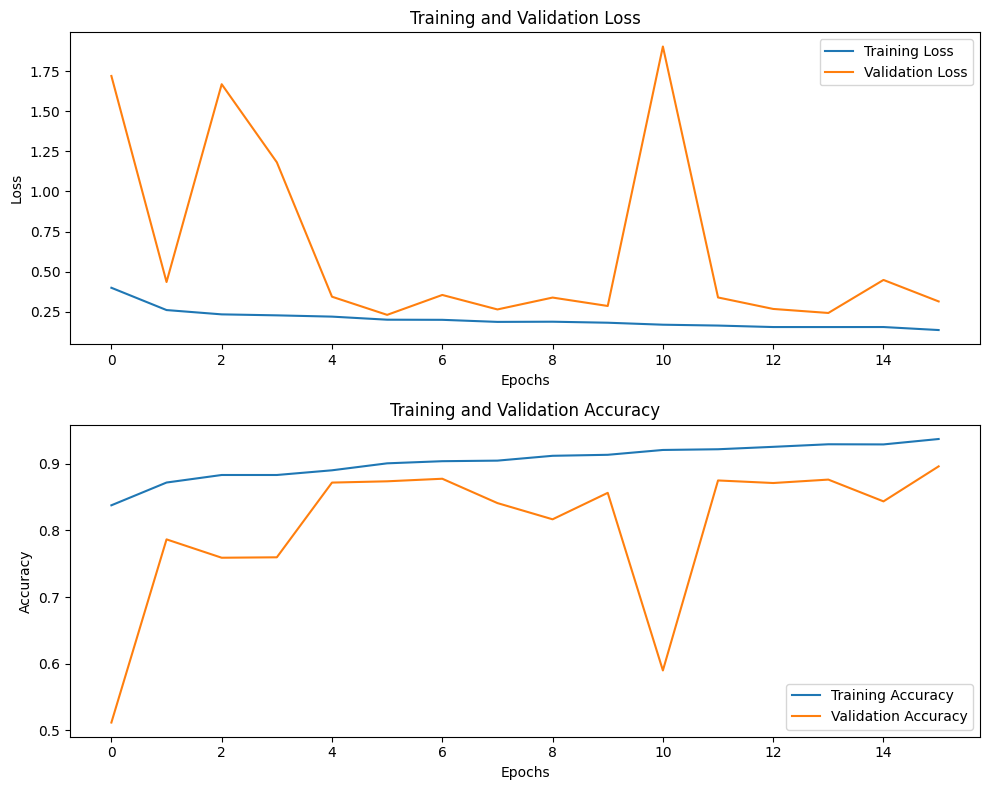

In [93]:
def plot_metrics(history):
    # Obtener las métricas de entrenamiento
    loss = history.history['loss']
    accuracy = history.history['binary_accuracy']
    
    # Obtener las métricas de validación si están disponibles
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_binary_accuracy']
        has_validation = True
    else:
        has_validation = False
    
    # Crear los subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot de la pérdida
    ax1.plot(loss, label='Training Loss')
    if has_validation:
        ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot de la precisión binaria
    ax2.plot(accuracy, label='Training Accuracy')
    if has_validation:
        ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

plot_metrics(history)

0.9974861


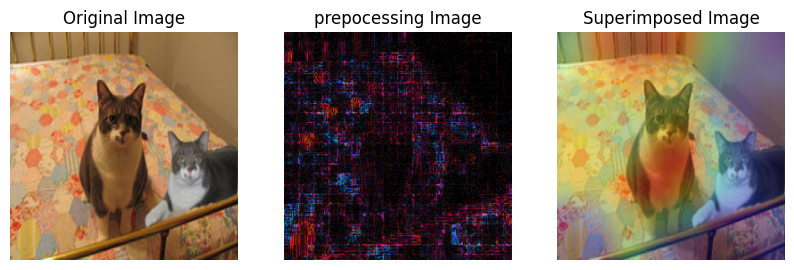

In [94]:
path = '../dataset/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
img = cv2.imread(path)
y_pred, img_heamap = model.predict(img, grad_cam=True)

img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

print(y_pred)

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ela(img))
plt.title('prepocessing Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_heamap)
plt.title('Superimposed Image')
plt.axis('off')

plt.show()

0.95997256


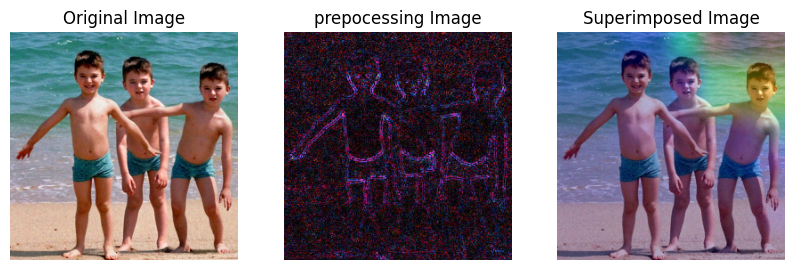

In [95]:
path = '../dataset/test/me_x_3.jpg'
img = cv2.imread(path)

y_pred, img_heamap = model.predict(img, grad_cam=True)

img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

print(y_pred)

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ela(img))
plt.title('prepocessing Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_heamap)
plt.title('Superimposed Image')
plt.axis('off')

plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
base_model.trainable = True

fine_tune_at = -10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
optimizer = Adam(1e-5)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_fine = model.fit(
    train_generator,
    epochs=total_epochs, 
    initial_epoch=history.epoch[-1],
    batch_size=batch_size, 
    validation_data=val_generator,
    callbacks=callbacks
)

### Showing the results

In [ ]:
acc = history.history['binary_accuracy'] + history_fine.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] + history_fine.history['val_binary_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluating the model

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.save_model('../model/custom_models/mobilnet')